In [0]:
# Check GPU enable on Colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   1091      0 --:--:-- --:--:-- --:--:--  1091
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
# Step up

from fastai.vision import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Dataset

In [0]:
path = untar_data(URLs.PETS)/"images"

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_5.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_76.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_95.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_103.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_152.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_69.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_123.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_103.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_31.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_195.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_131.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_142.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birma

## Data Augmentation

In [0]:
tfms = get_transforms(max_rotate=20,
                      max_zoom=1.3,
                      max_lighting=0.4,
                      max_warp=0.4,
                      p_affine=1.0,
                      p_lighting=1.0)

In [0]:
doc(get_transforms)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode="reflection"):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [0]:
bs = 64

In [0]:
data = get_data(224, bs, "zeros")

In [0]:
def _plot(i, j, ax):
    x, y = data.train_ds[3]
    x.show(ax, y=y)

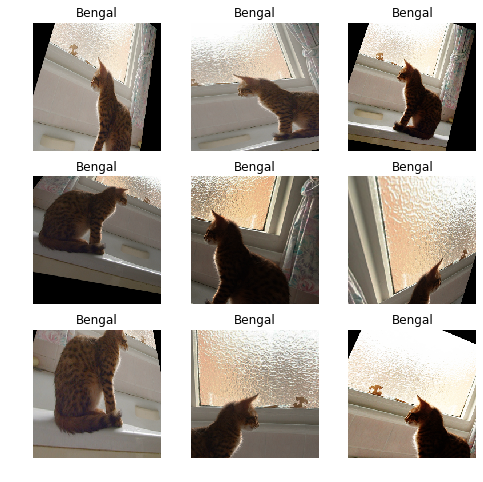

In [0]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [0]:
data = get_data(224, bs)

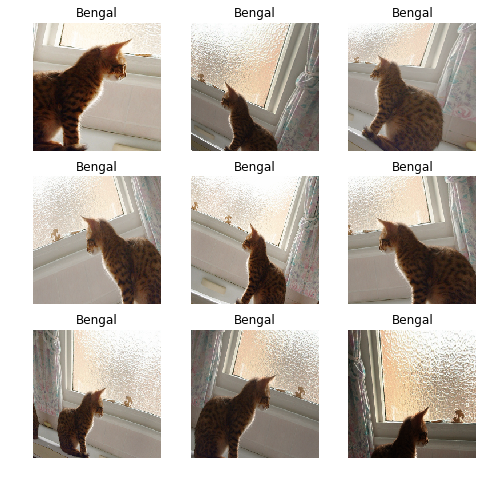

In [0]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

## Build model

In [0]:
gc.collect()

14506

In [0]:
learn = cnn_learner(data, 
                    models.resnet34,
                    metrics=error_rate,
                    bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:03, 28950561.87it/s]


In [0]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.415683,1.157435,0.256428,02:00
1,1.422374,0.383753,0.097429,01:59
2,0.896123,0.291294,0.072395,01:58


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.700080,0.305674,0.065629,02:06
1,0.641826,0.305926,0.070365,02:05


In [0]:
data = get_data(352,bs)
learn.data = data

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.632021,0.276184,0.048714,03:52
1,0.583454,0.277664,0.056834,03:46


In [0]:
learn.save("stage-1-352")

## Convolution Kernel

In [0]:
data = get_data(352, 16)

In [0]:
learn = cnn_learner(data,
                    models.resnet34,
                    metrics=error_rate,
                    bn_final=True)

In [0]:
learn.load("stage-1-352")

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
american_bulldog,wheaten_terrier,scottish_terrier,Bengal,leonberger
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
Sphynx,scottish_terrier,Maine_Coon,havanese,Birman
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

Category Sphynx

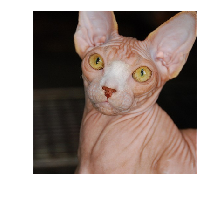

In [0]:
idx = 0
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [0]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [0]:
k.shape

torch.Size([1, 3, 3, 3])

In [0]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [0]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

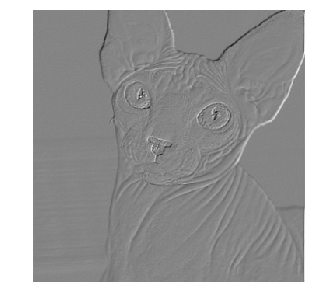

In [0]:
show_image(edge[0], figsize=(5, 5))

In [0]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________

## Heatmap

In [0]:
m = learn.model.eval()

In [0]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [0]:
hook_a, hook_g = hooked_backward()

In [0]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [0]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0, 352, 352, 0), interpolation="bilinear", cmap='magma')

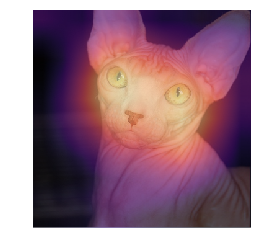

In [0]:
show_heatmap(avg_acts)

## Grad-CAM

In [0]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape, grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [0]:
mult = (acts * grad_chan[..., None, None]).mean(0)

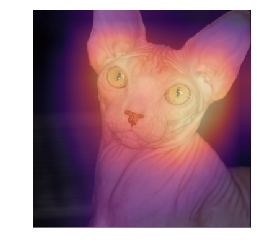

In [0]:
show_heatmap(mult)

In [0]:
fn = path/"pug_177.jpg"

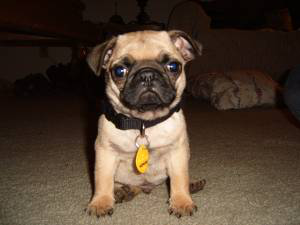

In [0]:
x = open_image(fn); x

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
hook_a,hook_g = hooked_backward()


In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

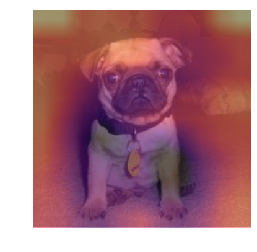

In [0]:
show_heatmap(mult)

In [0]:
data.classes[0]

'Abyssinian'